# Sprint Seq2Seq

## 1.このSprintについて

### Sprintの目的
- 系列データに関する応用例を学ぶ

### どのように学ぶか
- 公開されているコードを元に学んでいきます。

## 2.機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。



## 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。

<a href="https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py">
keras/lstm_seq2seq.py at master · keras-team/keras
</a>

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）

- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

###《文字単位のトークン化》

この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">
sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation
</a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint24/data/'
!wget 'http://www.manythings.org/anki/fra-eng.zip'
!unzip fra-eng.zip

/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint24/data
--2020-10-09 02:18:16--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 172.67.173.198, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6073837 (5.8M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.79M  19.3MB/s    in 0.3s    

2020-10-09 02:18:16 (19.3 MB/s) - ‘fra-eng.zip’ saved [6073837/6073837]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


### ■ 実行

In [ ]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint24/data/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 25s 200ms/step - loss: 1.1798 - accuracy: 0.7256 - val_loss: 1.0446 - val_accuracy: 0.7128
Epoch 2/100
125/125 [==============================] - 26s 207ms/step - loss: 0.8590 - accuracy: 0.7685 - val_loss: 0.8385 - val_accuracy: 0.7672
Epoch 3/100
125/125 [==============================] - 27s 214ms/step - loss: 0.6805 - accuracy: 0.8072 - val_loss: 0.7259 - val_accuracy: 0.7882
Epoch 4/100
125/125 [==============================] - 28s 221ms/step - loss: 0.5923 - accuracy: 0.8279 - val_loss: 0.6475 - val_accuracy: 0.8098
Epoch 5/100
125/125 [==============================] - 27s 212ms/step - loss: 0.5408 - accuracy: 0.8418 - val_loss: 0.6234 - val_accuracy: 0.8162
Epoch 6/100
125/125 [==============================] - 26s 209ms/step - loss: 0.5036 - accuracy: 0.8524 -

### ■ コードリーディング

#### ライブラリインポート
```
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
```

#### ハイパーパラメータ・変数設定
```
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'
```

#### テキスト前処理①
- fra.txtのデータからinput_text(English), target_text(French)を抽出。
- targetの開始文字はタブコード(\t)、終了文字は改行コード(\n)として処理。
- input, targetそれぞれのユニークな単語の集合を用意。

```
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
```

#### テキスト前処理②

input, targetそれぞれにおける、単語の最大文字数を取得。など
```
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
```

#### 単語毎にID採番

単語毎にIDを採番して辞書へ格納（key=char, value=id）
インプットデータのshapeの箱を用意（サンプル数, 単語の最大文字数, ユニークな単語数）
```
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
```

#### 文字単位でトークン化

- forでEnglish, Frenchを1単語ずつ抽出。
- さらにforでEnglish, Franchの単語から1文字ずつ抽出し[i行目, t文字目, 単語のID]の該当箇所に1を代入<br>
※つまりone-hot化。

```
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
```

#### encoder(LSTM)を定義
```
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
```

#### decoder(LSTM)を定義
```
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
```

Modelを生成
```
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 93)     23901       lstm_1[0][0]                     
==================================================================================================
Total params: 718,173
Trainable params: 718,173
Non-trainable params: 0
__________________________________________________________________________________________________

```

学習実行＆学習後のモデルをセーブ
```
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')
```

encoder/decoderモデルの生成

```
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, None, 71)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 335872    
=================================================================
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0


decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 93)     23901       lstm_1[1][0]                     
==================================================================================================
Total params: 382,301
Trainable params: 382,301
Non-trainable params: 0
__________________________________________________________________________________________________
None

```


keyとvalueを逆にしたdictを用意

```
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

```



エンコーダーのpredictを実行

```
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

```


ターゲットシーケンスの箱を用意して、最初に開始文字を入れる。

```
target_seq = np.zeros((1, 1, num_decoder_tokens))
# Populate the first character of target sequence with the start character.
target_seq[0, 0, target_token_index['\t']] = 1.
```

デコーダーのpredictを実行

```
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
```



```
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
```


最大長に達するか、停止文字になるまで繰り返し。

```
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
```

ターゲットシーケンスを更新してリターン。
```
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence
```

## 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。

<a href="https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning">
pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial
</a>

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

## 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [ ]:
!git clone https://github.com/pdollar/coco.git
%cd coco/PythonAPI/
!make
!python setup.py build
!python setup.py install
%cd ../../
!git clone https://github.com/yunjey/pytorch-tutorial.git
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint24/data/coco/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint24/data/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -

In [ ]:
!wget 'https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip'

--2020-10-09 09:04:09--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2020-10-09 09:04:09--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8543aa438202545fbc24b8aec7.dl.dropboxusercontent.com/cd/0/inline/BA5rT81njiNCY4CdcGatYiNkhJHgxXCNvLC-upNzM77eD7PW7VKVjz-ih3UXX5VFguO9JvgW4GMa5oth1880C6sdSZjXRQLB84kZRGey8Ct4kRqZAtjJwNIfuQ9r9OfhWAY/file# [following]
--2020-10-09 09:04:09--  https://uc8543aa438202545fbc24b8aec7.dl.dropboxusercontent.com/cd/0/inline/BA5rT81njiNCY4CdcGatYiNkhJHgxXCNvLC-upNzM77eD7PW7VKVjz-ih3UXX5VFguO9JvgW4GMa5oth1880C6sdSZjXRQLB84kZRGey8Ct4kRqZAtjJwNIfuQ9

In [ ]:
!wget 'https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip'

--2020-10-09 09:03:15--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2020-10-09 09:03:16--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd5c84ac6402a1c69c5a65fc47d.dl.dropboxusercontent.com/cd/0/inline/BA4PDTABSdogtVAdE_vSO2GaWddrh1sYoYGz--Ts9Yl2QmcHoVfEExYLMiTSufb9xwvVzfAtnHYNELSMZIa48OynSPza9Xx8WCIjrTfnD4g7pmjzE-sJ5BlmXUiEQBt822M/file# [following]
--2020-10-09 09:03:16--  https://ucd5c84ac6402a1c69c5a65fc47d.dl.dropboxusercontent.com/cd/0/inline/BA4PDTABSdogtVAdE_vSO2GaWddrh1sYoYGz--Ts9Yl2QmcHoVfEExYLMiTSufb9xwvVzfAtnHYNELSMZIa48OynSP

In [ ]:
!mkdir data
!mkdir models
!unzip vocap.zip
!unzip pretrained_model.zip
!mv vocab.pkl ./data/
!mv decoder-5-3000.pkl ./models/
!mv encoder-5-3000.pkl ./models/

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘models’: File exists
Archive:  vocap.zip
replace vocab.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vocab.pkl               
Archive:  pretrained_model.zip
replace encoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: encoder-5-3000.pkl      y
y

replace decoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: decoder-5-3000.pkl      


In [ ]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:03<00:00, 72.1MB/s]
<start> a group of giraffes standing next to each other . <end>


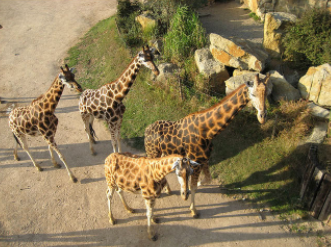

In [ ]:
from IPython.display import Image
Image('./png/example.png')

In [ ]:
!wget 'https://www.aflo.com/pages/creative/animal/img/mainImg20200311.jpg'
!python sample.py --image='mainImg20200311.jpg'

--2020-10-09 10:17:10--  https://www.aflo.com/pages/creative/animal/img/mainImg20200311.jpg
Resolving www.aflo.com (www.aflo.com)... 113.37.220.150
Connecting to www.aflo.com (www.aflo.com)|113.37.220.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267874 (262K) [image/jpeg]
Saving to: ‘mainImg20200311.jpg’

mainImg20200311.jpg 100%[===================>] 261.60K   700KB/s    in 0.4s    

2020-10-09 10:17:12 (700 KB/s) - ‘mainImg20200311.jpg’ saved [267874/267874]

<start> a group of sheep standing next to a pile of rocks . <end>


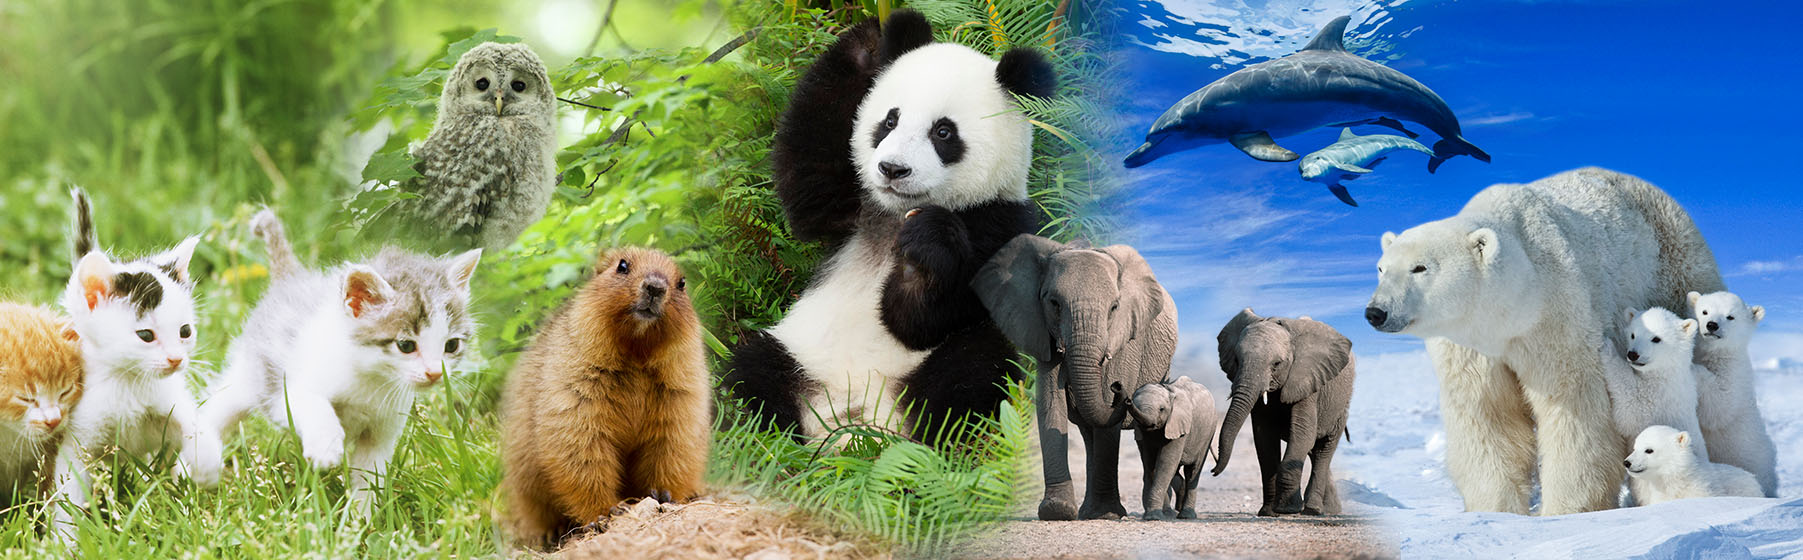

In [ ]:
Image('mainImg20200311.jpg')

In [ ]:
!wget 'https://img.cinematoday.jp/a/N0066659/_size_560x/_v_1411592400/main.jpg'
!python sample.py --image='main.jpg'

--2020-10-09 10:18:55--  https://img.cinematoday.jp/a/N0066659/_size_560x/_v_1411592400/main.jpg
Resolving img.cinematoday.jp (img.cinematoday.jp)... 23.55.220.154, 23.55.220.139, 2600:1407:a800::1738:a98b, ...
Connecting to img.cinematoday.jp (img.cinematoday.jp)|23.55.220.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27651 (27K) [image/jpeg]
Saving to: ‘main.jpg’

main.jpg            100%[===================>]  27.00K  --.-KB/s    in 0.001s  

2020-10-09 10:18:56 (27.1 MB/s) - ‘main.jpg’ saved [27651/27651]

<start> a man wearing a hat and tie in a suit . <end>


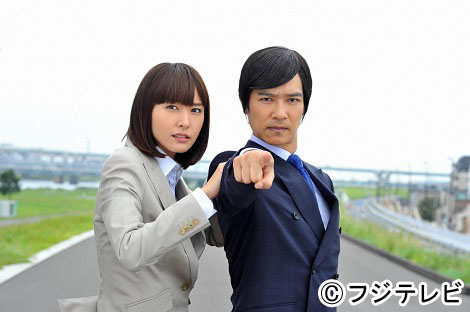

In [ ]:
Image('main.jpg')

<start> a man wearing a hat and tie in a suit . <end>
⇒帽子をかぶってスーツを着た男

かつらなのは見破れる様子。ガッキーは無視された。

## 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

下記フローで可能な様子。

0. ONNXのチュートリアルを確認（<a href="https://github.com/onnx/tutorials">https://github.com/onnx/tutorials</a>）
1. PyTorchモデルをONNXモデル形式にエクスポーﾄ
2. ONNXモデルをTFにインポート